In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
from perceptrone import plot, Classifier
%matplotlib inline

In [2]:
d1 = json.load(open('train_01.json'))
d2 = json.load(open('train_02.json'))

In [3]:
d = []
r = {'inside':1, 'outside':-1}
for k in d1.keys():
    _df = pd.DataFrame(d1[k], columns=['A', 'B'])
    _df['class'] = r[k]
    d.append(_df)
df1 = pd.concat(d, axis=0, ignore_index=True)

In [4]:
d = []
r = {'inside':1, 'outside':-1}
for k in d2.keys():
    _df = pd.DataFrame(d2[k], columns=['A', 'B'])
    _df['class'] = r[k]
    d.append(_df)
df2 = pd.concat(d, axis=0, ignore_index=True)

In [5]:
df1

,A,B,class
0,0.729520,0.728634,1
1,0.826506,0.940316,1
2,0.602314,0.489100,1
3,0.792430,0.972460,1
4,0.373906,0.380795,1
5,0.521383,0.701165,1
6,0.579949,0.860210,1
7,0.447271,0.232087,1
8,0.826693,0.970862,1
9,0.209609,0.079489,1


In [6]:
train1, test1 = train_test_split(df1, test_size=0.2)

In [7]:
train2, test2 = train_test_split(df2, test_size=0.2)

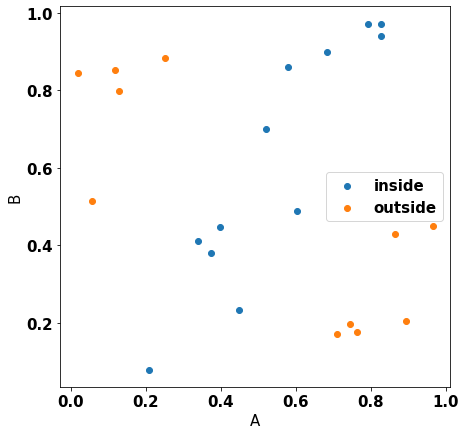

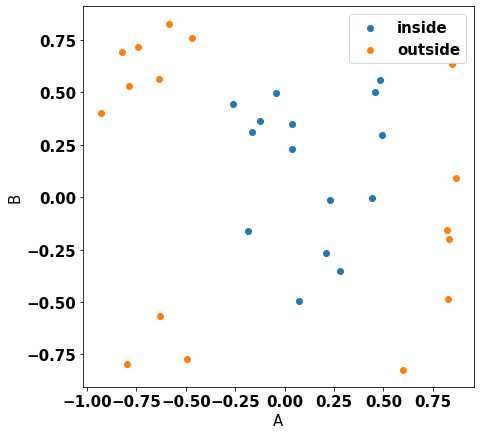

In [8]:
plot(train1)
plot(train2)

# so we need to use quadratic forms

A     0.912846
B    -1.682838
A2   -5.535606
B2   -1.400736
AB    7.044705
C     0.605254
Name: 25, dtype: float64


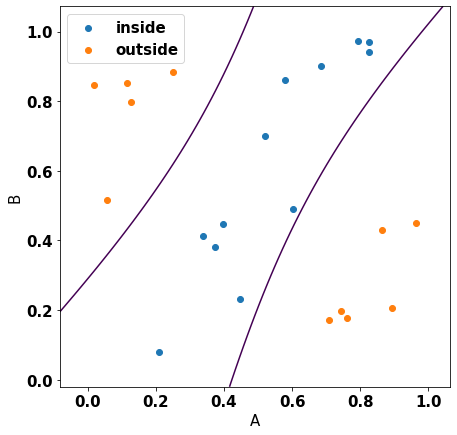

In [9]:
C = Classifier(train1)
C.train()

In [10]:
dftest1 = C.test(test1)
test1.join(dftest1.set_index(['A', 'B']), on=['A', 'B']).drop(columns=['A2','B2', 'AB','C'])

,A,B,class,class_detected
14,0.846590,0.126805,-1,-1
0,0.729520,0.728634,1,1
23,0.685063,0.011556,-1,-1
17,0.196516,0.756340,-1,-1
13,0.261937,0.207272,1,1
21,0.073085,0.706869,-1,-1


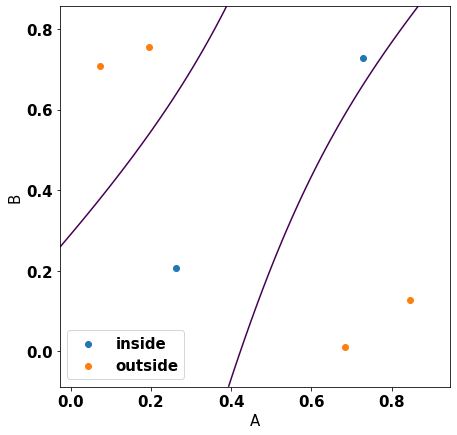

In [11]:
C.plot(test1)

A     0.240445
B     0.278717
A2   -2.798730
B2   -0.884527
AB    0.480424
C     0.574781
Name: 29, dtype: float64


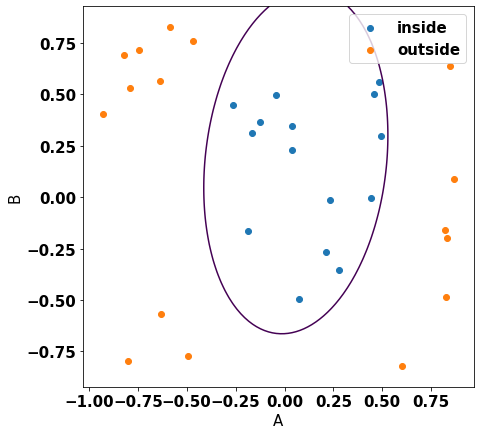

In [12]:
C2 = Classifier(train2)
C2.train()

In [13]:
dftest2 = C2.test(test2)
test2.join(dftest2.set_index(['A', 'B']), on=['A', 'B']).drop(columns=['A2','B2', 'AB','C'])

,A,B,class,class_detected
6,0.619550,0.039807,1,-1
37,-0.696535,0.034561,-1,-1
20,-0.785869,-0.236199,-1,-1
0,0.672175,0.184493,1,-1
4,0.199091,-0.207021,1,1
10,0.642289,-0.003541,1,-1
21,-0.710011,0.414047,-1,-1
23,-0.457970,0.661598,-1,-1


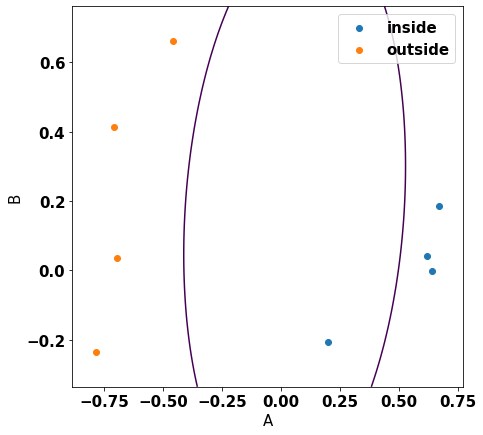

In [14]:
C2.plot(test2)